In [470]:
%matplotlib inline
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [471]:
ols_model = LinearRegression()

In [472]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=10):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

In [473]:
def froll_sum(x): 
    # Convert daily return to monthly return, use fix_rolling_sum function
    tmp = []
    for i in range(int(len(x)/21)): # 21 represents the trading days for one month
        res = np.sum(x[i*21:(i+1)*21])
        tmp.append(res)
    return tmp

In [474]:
## Newey-West Adjustment For a Time-Series Data, e.g. Lambdas (factor returns)
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

Import Data

In [475]:
# Import excessive market return (J203T - Rf)
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

Import risk-free rate (91-day T-Bill)

In [476]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)

Import listed stock returns on the JSE

In [477]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

Drop the columns of stock returns that full of 0s or NAs and replace consecutive 0s with NAs

In [478]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR = df_SR.dropna(axis = 0, how = 'all')
df_SR = df_SR.apply(replacer)

In [479]:
df_SR.dropna(axis=1)

,MTN.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,ACL.SJ.Equity,...,AFE.SJ.Equity,DSY.SJ.Equity,MRP.SJ.Equity,APN.SJ.Equity,AFX.SJ.Equity,SUR.SJ.Equity,DRD.SJ.Equity,SUI.SJ.Equity,WBO.SJ.Equity,SNT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.012821,-0.024693,-0.040734,-0.009132,-0.004376,-0.016666,-0.048790,-0.025318,-0.079755,-0.013234,...,0.000000,-0.004491,0.000000,0.000000,-0.013889,0.000000,-0.020201,-0.020620,-0.040822,0.000000
2000-01-06,0.075623,-0.077962,-0.047886,0.015175,-0.015470,0.024898,-0.021053,0.011332,-0.015207,0.034932,...,0.034689,-0.018187,0.000000,-0.024698,0.020762,0.000000,-0.031094,0.000000,0.000000,-0.032789
2000-01-07,0.079437,0.013423,0.034816,0.041304,0.011808,0.032262,0.004246,0.068053,0.033902,0.147389,...,0.100805,-0.086180,0.007117,0.060625,0.020340,0.021979,0.031094,0.010363,0.020619,0.003325
2000-01-10,0.066809,0.089231,0.076001,0.020973,0.100433,0.023531,0.000000,0.071096,0.016530,0.043488,...,0.000000,0.014887,0.021053,0.045994,0.036248,0.000000,0.005086,0.000000,0.010152,0.043874
2000-01-11,0.020203,0.070618,-0.050029,-0.044366,0.003312,-0.012481,-0.044182,-0.055430,-0.009151,-0.090891,...,-0.017275,-0.004934,0.000000,0.220877,-0.003241,0.021506,0.000000,0.006167,0.010050,0.017337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-27,-0.000119,0.004612,0.003673,0.012542,0.003590,0.004883,0.009022,-0.001472,0.025673,-0.080043,...,-0.027909,0.010917,0.007941,0.010903,0.005886,-0.030334,0.027399,0.011287,-0.010159,-0.021661


Calculate the Excess Stock Returns 

In [480]:
df_Ex_SR = df_SR-df_RF.values

Import the Factor Realizations (Mimicking portfolio returns)

In [481]:
df_FF3 = pd.read_csv('df_FF3.csv')
df_FF3.Dates = df_FF3.Dates.apply(lambda x: x[:10])
df_FF3.set_index('Dates',inplace=True)

In [482]:
df_FF4 = pd.read_csv('df_FF4.csv')
df_FF4.Dates = df_FF4.Dates.apply(lambda x:x[:10])
df_FF4.set_index('Dates',inplace=True)

In [483]:
df_FF5 = pd.read_csv('df_FF5.csv')
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])
df_FF5.set_index('Dates',inplace=True)

In [493]:
from scipy.stats.mstats import winsorize
df_FF5 = df_FF5.apply(lambda x: winsorize(x, (0.01, 0.01))) #For example, we will write (0.01, 0.01). This means we want to apply quantile(0.01) and quantile(0.99) as a boundary.
df_Ex_SR = df_Ex_SR.apply(lambda x: winsorize(x, (0.01, 0.01)))

Import Firm Characteristics 

In [484]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')
df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])
df_ln_Size.set_index('Dates',inplace=True)

In [485]:
df_PE = pd.read_csv('df_std_PE.csv')
df_PE.Dates = df_PE.Dates.apply(lambda x:x[:10])
df_PE.set_index('Dates',inplace=True)

In [486]:
df_OP = pd.read_csv('df_std_OP.csv')
df_OP.Dates = df_OP.Dates.apply(lambda x:x[:10])
df_OP.set_index('Dates',inplace=True)

In [487]:
df_INV = pd.read_csv('df_std_INV.csv')
df_INV.Dates = df_INV.Dates.apply(lambda x:x[:10])
df_INV.set_index('Dates',inplace=True)

Import 18 double-sorted portfolios returns

In [488]:
df_18_PR = pd.read_csv('df_18_PR.csv')
df_18_PR.Dates = df_18_PR.Dates.apply(lambda x:x[:10])
df_18_PR.set_index('Dates',inplace=True)

Import Firm Characteristics of 18 double-sorted portfolios

In [489]:
df_18_std_Size = pd.read_csv('df_18_std_size.csv')
df_18_std_Size.Dates = df_18_std_Size.Dates.apply(lambda x:x[:10])
df_18_std_Size.set_index('Dates',inplace=True)

In [490]:
df_18_std_PE = pd.read_csv('df_18_std_PE.csv')
df_18_std_PE.Dates = df_18_std_PE.Dates.apply(lambda x:x[:10])
df_18_std_PE.set_index('Dates',inplace=True)

In [491]:
df_18_std_OP = pd.read_csv('df_18_std_OP.csv')
df_18_std_OP.Dates = df_18_std_OP.Dates.apply(lambda x:x[:10])
df_18_std_OP.set_index('Dates',inplace=True)

In [492]:
df_18_std_INV = pd.read_csv('df_18_std_INV.csv')
df_18_std_INV.Dates = df_18_std_INV.Dates.apply(lambda x:x[:10])
df_18_std_INV.set_index('Dates',inplace=True)

In [550]:
df_FF3.describe()

,MR_RF,SMB,HML
count,4750.000000,4750.000000,4750.000000
mean,0.000320,-0.000271,0.000281
std,0.011617,0.007110,0.007457
min,-0.074100,-0.070567,-0.128500
25%,-0.005700,-0.004158,-0.003700
50%,0.000100,0.000000,0.000000
75%,0.006700,0.003700,0.004100
max,0.068500,0.084067,0.055750


In [551]:
df_FF3 = df_FF3.apply(lambda x: winsorize(x, (0.1,0.1)))
df_FF3.describe()

,MR_RF,SMB,HML
count,4750.000000,4750.000000,4750.000000
mean,0.000369,-0.000221,0.000225
std,0.008100,0.005073,0.005120
min,-0.013000,-0.008433,-0.007900
25%,-0.005700,-0.004158,-0.003700
50%,0.000100,0.000000,0.000000
75%,0.006700,0.003700,0.004100
max,0.013000,0.007800,0.008500


## Constant Beta

In [408]:
df_Ex_SR.dropna(axis = 1)

,MTN.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,ACL.SJ.Equity,...,AFE.SJ.Equity,DSY.SJ.Equity,MRP.SJ.Equity,APN.SJ.Equity,AFX.SJ.Equity,SUR.SJ.Equity,DRD.SJ.Equity,SUI.SJ.Equity,WBO.SJ.Equity,SNT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.012542,-0.024971,-0.041012,-0.009411,-0.004655,-0.016945,-0.049069,-0.025597,-0.080034,-0.013512,...,-0.000279,-0.004770,-0.000279,-0.000279,-0.014168,-0.000279,-0.020480,-0.020899,-0.041101,-0.000279
2000-01-06,0.075345,-0.078240,-0.048165,0.014896,-0.015749,0.024619,-0.021332,0.011053,-0.015486,0.034653,...,0.034411,-0.018466,-0.000279,-0.024976,0.020483,-0.000279,-0.031373,-0.000279,-0.000279,-0.033068
2000-01-07,0.079162,0.013148,0.034541,0.041029,0.011533,0.031987,0.003971,0.067778,0.033627,0.147114,...,0.100530,-0.086455,0.006842,0.060350,0.020065,0.021704,0.030819,0.010088,0.020344,0.003050
2000-01-10,0.066534,0.088956,0.075726,0.020698,0.100158,0.023256,-0.000275,0.070821,0.016254,0.043213,...,-0.000275,0.014612,0.020778,0.045719,0.035973,-0.000275,0.004811,-0.000275,0.009877,0.043599
2000-01-11,0.019928,0.070342,-0.050305,-0.044641,0.003037,-0.012756,-0.044457,-0.055705,-0.009426,-0.091166,...,-0.017550,-0.005209,-0.000275,0.220602,-0.003517,0.021231,-0.000275,0.005892,0.009775,0.017062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-26,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-27,-0.000308,0.004422,0.003483,0.012353,0.003400,0.004694,0.008833,-0.001661,0.025484,-0.080232,...,-0.028098,0.010728,0.007752,0.010714,0.005697,-0.030524,0.027209,0.011097,-0.010348,-0.021851


In [108]:
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=df_18_PR, factors= df_FF5, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 18   R-squared:                      0.5513
No. Factors:                          5   J-statistic:                    21.140
No. Observations:                  4750   P-value                         0.0702
Date:                  Thu, May 26 2022   Distribution:                 chi2(13)
Time:                          19:20:47                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MR_RF          0.0003     0.0002     1.3707     0.1705     -0.0001      0.0007
SMB           -0.0002     0.0001    -2.0155     0.0438     -0.0004  -5.617e-06
HML            0.0003     0.0001     2.5721     0.0101   7.004e-05      0.0005
RMW            0.0004     0.0001     2.9925     0.0028      0.0001      0.0006
CMA           -0.0002     0.0001    -1.4170     0.1565     -0.0004   6.541e-05
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [156]:
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=df_Ex_SR.loc[df_FF5.index,:].dropna(axis = 1), factors= pd.concat([df_FF5, df_FF4.loc[:,"WML"]], axis = 1), risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                191   R-squared:                      0.0380
No. Factors:                          6   J-statistic:                 7.831e+04
No. Observations:                  4750   P-value                         0.0000
Date:                  Thu, May 26 2022   Distribution:                chi2(185)
Time:                          20:10:57                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MR_RF          0.0002     0.0002     0.8660     0.3865     -0.0002      0.0006
SMB           -0.0003     0.0002    -1.8013     0.0717     -0.0007   2.853e-05
HML           -0.0001     0.0003    -0.4419     0.6586     -0.0006      0.0004
RMW            0.0004     0.0003     1.4625     0.1436     -0.0001      0.0009
CMA           -0.0005     0.0004    -1.5023     0.1330     -0.0012      0.0002
WML            0.0008     0.0005     1.4218     0.1551     -0.0003      0.0018
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [411]:
df_SR.index = pd.to_datetime(df_SR.index)
df_Ex_SR.index = pd.to_datetime(df_Ex_SR.index)
df_FF5.index = pd.to_datetime(df_FF5.index)
df_FF4.index = pd.to_datetime(df_FF4.index)
df_18_PR.index = pd.to_datetime(df_18_PR.index)
df_ln_Size.index = pd.to_datetime(df_ln_Size.index)
df_MR.index = pd.to_datetime(df_MR.index)

In [163]:
df_Ex_SR.loc[df_FF5.index,:].dropna(axis = 1).shape[0]

4750

In [164]:
pd.concat([df_FF5, df_FF4.loc[:,"WML"]], axis = 1).shape[0]

4750

In [166]:
from linearmodels.panel.model import PooledOLS

In [189]:
df_Ex_SR_tmp = df_Ex_SR.loc[df_FF5.index,:].dropna(axis = 1)

In [187]:
fm_mod = PooledOLS(dependent= df_Ex_SR_tmp, exog= df_ln_Size.loc[df_FF5.index,df_Ex_SR_tmp.columns])
res_fm = fm_mod.fit()
res_fm.summary

/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/linearmodels/shared/exceptions.py:37: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


Dep. Variable:,Dep,R-squared:,2.285e-07
Estimator:,PooledOLS,R-squared (Between):,0.0184
No. Observations:,843255,R-squared (Within):,-4.23e-06
Date:,"Thu, May 26 2022",R-squared (Overall):,2.285e-07
Time:,21:59:04,Log-likelihood,1.727e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.1927
Entities:,189,P-value,0.6607
Avg Obs:,4461.7,Distribution:,"F(1,843254)"
Min Obs:,1830.0,,
Max Obs:,4750.0,F-statistic (robust):,0.1927


In [215]:
df_Ex_SR.columns[6]

'NTC.SJ.Equity'

In [232]:
mod_ols = sm.OLS(endog=df_Ex_SR.loc[df_MR.index,df_Ex_SR.columns[19]], exog=df_MR)
res_ols = mod_ols.fit()
res_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          FPT.SJ.Equity   R-squared (uncentered):                   0.028
Model:                            OLS   Adj. R-squared (uncentered):              0.028
Method:                 Least Squares   F-statistic:                              151.4
Date:                Fri, 27 May 2022   Prob (F-statistic):                    2.58e-34
Time:                        00:24:12   Log-Likelihood:                          15367.
No. Observations:                5215   AIC:                                 -3.073e+04
Df Residuals:                    5214   BIC:                                 -3.073e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MR_RF          0.1874      0.015     12.304      0.000       0.158       0.217
==============================================================================
Omnibus:                      886.759   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10049.618
Skew:                          -0.461   Prob(JB):                         0.00
Kurtosis:                       9.738   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [251]:
def froll_sum(x): 
    # Convert daily return to monthly return, use fix_rolling_sum function
    tmp = []
    for i in range(int(len(x)/21)): # 21 represents the trading days for one month
        res = np.nansum(x[i*21:(i+1)*21])
        tmp.append(res)
    return tmp

In [271]:
m_df_Ex_SR = df_Ex_SR.dropna(axis = 1).apply(lambda x: froll_sum(x))

In [272]:
m_df_Ex_SR

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,ABI.SJ.Equity,SGG.SJ.Equity,CXT.SJ.Equity,GIJ.SJ.Equity,PAM.SJ.Equity,CHE.SJ.Equity,JCG.SJ.Equity,CRM.SJ.Equity,CLE.SJ.Equity,WES.SJ.Equity
0,0.072165,-0.020800,0.356718,0.065927,0.124700,-0.150558,0.018565,0.115681,0.026352,0.004518,...,0.007738,-0.041745,-0.101678,0.152756,0.014380,-0.018326,-0.157433,0.051626,-0.032745,0.007046
1,-0.321464,-0.085416,0.114407,-0.245906,-0.148942,-0.083488,0.148780,0.017204,-0.098995,-0.170245,...,-0.170885,-0.117745,-0.005370,-0.070510,-0.242855,0.003177,0.250925,-0.021371,0.011724,0.016880
2,-0.044659,-0.065513,-0.050221,-0.614471,-0.046486,0.094156,0.054017,-0.293089,-0.024135,-0.043873,...,-0.081568,-0.034965,-0.132396,-0.178159,-0.171199,-0.085095,-0.207044,0.171524,0.156943,-0.052975
3,-0.002750,-0.105868,0.002869,0.041823,-0.070462,-0.095661,-0.150011,-0.192046,-0.144373,-0.030245,...,-0.059630,-0.056723,-0.213079,-0.176387,-0.057586,0.035208,-0.223268,-0.046815,-0.086433,-0.235004
4,-0.300411,-0.201712,-0.069580,-0.248154,-0.239998,-0.087830,-0.062751,-0.037665,-0.093176,0.155355,...,0.058155,0.004879,0.137516,-0.064947,0.031700,-0.032500,0.075671,-0.035616,-0.073470,-0.005592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,-0.003894,-0.003894,-0.057368,-0.003894,-0.003894,-0.003894,-0.117104,-0.003894,-0.045106,-0.158582,...,-0.003894,-0.003894,-0.003894,-0.003894,-0.003894,-0.003894,-0.003894,-0.003894,-0.003894,-0.003894
244,-0.003835,-0.003835,-0.015162,-0.003835,-0.404527,-0.003835,0.114683,-0.003835,0.095469,0.036686,...,-0.003835,-0.003835,-0.003835,-0.003835,-0.003835,-0.003835,-0.003835,-0.003835,-0.003835,-0.003835
245,-0.003772,-0.003772,-0.046436,-0.003772,-0.003772,-0.003772,0.071008,-0.003772,0.011802,-0.038184,...,-0.003772,-0.003772,-0.003772,-0.003772,-0.003772,-0.003772,-0.003772,-0.003772,-0.003772,-0.003772
246,-0.003872,-0.003872,-0.018684,-0.003872,-0.003872,-0.003872,0.093817,-0.003872,0.013172,0.030468,...,-0.003872,-0.003872,-0.003872,-0.003872,-0.003872,-0.003872,-0.003872,-0.003872,-0.003872,-0.003872


In [331]:
# FM_OLS Regression
# 1st Stage of FM_OLS Regression/ Beta Estimation
# Time-Series Regression
df_MR_tmp = df_MR
df_Ex_SR_tmp = df_Ex_SR.loc[df_MR.index, :].dropna(axis = 1)
betas = []

for j in df_Ex_SR_tmp.columns:
    OLS = sm.OLS(df_Ex_SR_tmp.loc[:, j].values.astype(
        np.float64), df_MR_tmp.values.astype(np.float64))
    res = OLS.fit(cov_type="HC1")
    b = list(res.params)
    betas.append(b)
df_betas = pd.DataFrame(betas).rename(columns={0:"MKT"})


# 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
# Cross-sectional Regression
lambdas = []
df_Ex_SR_tmp_T = df_Ex_SR_tmp.T
for k in df_Ex_SR_tmp_T.columns:
    OLS = sm.OLS(df_Ex_SR_tmp_T.loc[:, k].values, 
        df_betas["MKT"].astype(np.float64))
    res = OLS.fit(cov_type="HC1")
    l = list(res.params)
    lambdas.append(l)

In [332]:
df_betas

,MKT
0,0.097357
1,0.144294
2,1.040482
3,0.127970
4,0.653292
...,...
181,0.028121
182,0.023760
183,0.056708
184,0.035313


In [333]:
np.mean(lambdas)

-4.63255989511288e-05

In [334]:
stats.ttest_1samp(lambdas, 0)

Ttest_1sampResult(statistic=array([-0.23721169]), pvalue=array([0.81250189]))

In [406]:
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=df_Ex_SR.dropna(axis = 1), factors= df_MR, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                186   R-squared:                      0.0175
No. Factors:                          1   J-statistic:                    191.67
No. Observations:                  5215   P-value                         0.3530
Date:                  Sat, May 28 2022   Distribution:                chi2(185)
Time:                          02:11:02                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MR_RF      -4.841e-05     0.0002    -0.2455     0.8061     -0.0004      0.0003
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [345]:
res_ols.risk_premia[0]

-4.840516038811684e-05

<AxesSubplot:xlabel='Dates'>

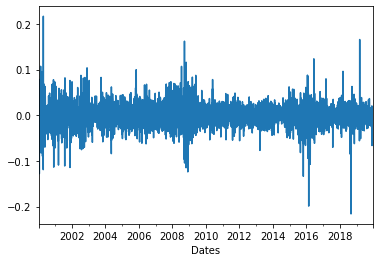

In [326]:
df_Ex_SR.iloc[:,2].plot()

<AxesSubplot:xlabel='Dates'>

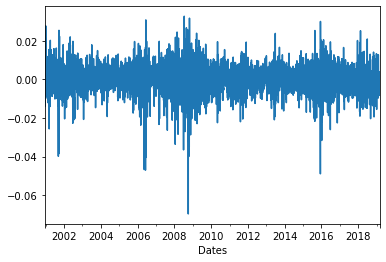

In [351]:
df_18_PR.iloc[:,4].plot()

In [552]:
m_df_18_PR = df_18_PR.apply(lambda x: froll_sum(x))
m_df_FF5 = df_FF5.apply(lambda x: froll_sum(x))

In [553]:
model_ols = LinearFactorModel(portfolios=m_df_18_PR, factors= m_df_FF5, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 18   R-squared:                      0.5688
No. Factors:                          5   J-statistic:                    26.633
No. Observations:                   226   P-value                         0.0140
Date:                  Sat, May 28 2022   Distribution:                 chi2(13)
Time:                          03:33:43                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MR_RF          0.0036     0.0044     0.8355     0.4035     -0.0049      0.0122
SMB           -0.0041     0.0018    -2.2976     0.0216     -0.0076     -0.0006
HML            0.0061     0.0021     2.8401     0.0045      0.0019      0.0102
RMW            0.0065     0.0023     2.8553     0.0043      0.0020      0.0109
CMA           -0.0033     0.0022    -1.5053     0.1323     -0.0077      0.0010
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [364]:
model_ols = LinearFactorModel(portfolios = df_18_PR, factors= df_FF5, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 18   R-squared:                      0.5513
No. Factors:                          5   J-statistic:                    21.140
No. Observations:                  4750   P-value                         0.0702
Date:                  Sat, May 28 2022   Distribution:                 chi2(13)
Time:                          01:34:13                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MR_RF          0.0003     0.0002     1.3707     0.1705     -0.0001      0.0007
SMB           -0.0002     0.0001    -2.0155     0.0438     -0.0004  -5.617e-06
HML            0.0003     0.0001     2.5721     0.0101   7.004e-05      0.0005
RMW            0.0004     0.0001     2.9925     0.0028      0.0001      0.0006
CMA           -0.0002     0.0001    -1.4170     0.1565     -0.0004   6.541e-05
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [460]:
df_FF5_tmp = df_FF5
df_Ex_SR_tmp = df_Ex_SR.loc[df_FF5_tmp.index, :].dropna(axis = 1)
betas = []

for j in df_Ex_SR_tmp.columns:
    OLS = sm.OLS(df_Ex_SR_tmp.loc[:, j].values.astype(
        np.float64), df_FF5_tmp.values.astype(np.float64))
    res = OLS.fit(cov_type="HC1")
    b = list(res.params)
    betas.append(b)
df_betas = pd.DataFrame(betas)


# 2nd Stage of FM_OLS Regression/ Risk Premium Estimation
# Cross-sectional Regression
lambdas = []
all_lambdas = []
df_Ex_SR_tmp_T = df_Ex_SR_tmp.T
for k in tqdm(df_Ex_SR_tmp_T.columns):
    OLS = sm.OLS(df_Ex_SR_tmp_T.loc[:, k].values, 
        df_betas.astype(np.float64))
    res = OLS.fit(cov_type="HC1")
    l = pd.DataFrame(res.params).T
    lambdas.append(l)


100%|██████████| 4750/4750 [00:04<00:00, 979.06it/s] 


In [461]:
df_betas

,0,1,2,3,4
0,0.851082,-0.518358,0.000883,0.127713,-0.007495
1,0.580152,-0.310619,0.100502,-0.286521,-0.086860
2,0.446188,-0.422544,-0.010831,0.090795,0.017296
3,0.501757,-0.640108,-0.139435,0.247611,0.102298
4,1.118059,-0.010157,-0.026024,-0.000991,0.059185
...,...,...,...,...,...
68,0.214074,-0.261282,-0.038723,0.012467,0.004447
69,0.174918,-0.118946,-0.107943,0.118267,-0.021664
70,0.270469,0.108459,0.065425,0.111565,0.011571
71,0.291847,0.355868,0.006307,-0.094990,0.000960


In [462]:
all_lambdas = pd.DataFrame(np.concatenate(lambdas))
all_lambdas

,0,1,2,3,4
0,0.009127,0.019836,-0.009591,0.010249,-0.039115
1,-0.012399,-0.003250,-0.012932,-0.006868,0.077512
2,0.032053,0.015721,0.001200,0.014728,-0.016301
3,-0.000445,0.000033,-0.000138,-0.000088,-0.000109
4,-0.000445,0.000033,-0.000138,-0.000088,-0.000109
...,...,...,...,...,...
4745,-0.004601,-0.007674,0.013444,-0.021011,0.020563
4746,-0.003419,-0.018331,-0.023171,-0.081433,-0.101232
4747,-0.009695,-0.007186,-0.007975,0.042718,0.033873
4748,-0.009806,-0.017347,0.012659,-0.007890,-0.062196


In [463]:
all_lambdas.apply(lambda x: np.mean(x, axis = 0))

0    0.000650
1    0.000232
2    0.001901
3    0.000456
4    0.001912
dtype: float64

In [464]:
all_lambdas.apply(lambda x: stats.ttest_1samp(x,0)[0])

0    3.186619
1    1.208660
2    4.955117
3    1.433455
4    3.419914
dtype: float64

In [558]:
model_ols = LinearFactorModel(portfolios=df_Ex_SR.loc[df_FF5.index,:].dropna(axis = 1), factors= df_FF5, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:                 73   R-squared:                      0.0982
No. Factors:                          5   J-statistic:                    142.57
No. Observations:                  4750   P-value                         0.0000
Date:                  Sat, May 28 2022   Distribution:                 chi2(68)
Time:                          03:47:45                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
MR_RF          0.0006     0.0002     2.6804     0.0074      0.0002      0.0011
SMB            0.0002     0.0003     0.8767     0.3807     -0.0003      0.0008
HML            0.0019     0.0005     3.5611     0.0004      0.0008      0.0029
RMW            0.0004     0.0006     0.6437     0.5198     -0.0008      0.0016
CMA            0.0018     0.0011     1.6903     0.0910     -0.0003      0.0039
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [556]:
df_Ex_SR.describe()

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
count,610.000000,1383.000000,5215.000000,2265.000000,5215.000000,1923.000000,5215.000000,1015.000000,5215.000000,5215.000000,...,2248.000000,1414.000000,2981.000000,219.000000,413.000000,288.000000,1949.000000,1312.000000,1077.000000,3430.000000
mean,0.003633,0.000769,0.000114,0.000544,0.002450,0.001217,0.000410,-0.000081,0.000247,0.000141,...,-0.000868,0.000950,0.000604,0.003509,0.000949,0.001774,0.001059,0.001399,0.000742,0.000754
std,0.053905,0.027874,0.021901,0.025724,0.059552,0.018136,0.017188,0.036281,0.018023,0.019784,...,0.021490,0.014053,0.021523,0.014268,0.013816,0.018574,0.022435,0.021304,0.011594,0.023860
min,-0.043042,-0.049925,-0.062193,-0.059983,-0.224052,-0.039289,-0.047144,-0.061751,-0.049104,-0.056222,...,-0.060519,-0.025407,-0.057156,-0.009381,-0.016888,-0.020534,-0.035872,-0.038560,-0.020528,-0.055415
25%,-0.016302,-0.013440,-0.011874,-0.009751,-0.011556,-0.007232,-0.009529,-0.021532,-0.010119,-0.010834,...,-0.008499,-0.002732,-0.000763,-0.009270,-0.008510,-0.012162,-0.000194,-0.004817,-0.005004,-0.009363
50%,-0.000269,-0.000264,-0.000193,-0.000244,-0.000195,-0.000228,-0.000197,-0.000292,-0.000191,-0.000189,...,-0.000161,-0.000173,-0.000181,-0.000016,-0.000191,-0.000195,-0.000162,-0.000190,-0.000189,-0.000183
75%,0.014249,0.011599,0.012036,0.009623,0.010975,0.008793,0.009848,0.015648,0.010520,0.011261,...,0.005958,0.003233,0.000488,0.009676,0.007989,0.012708,-0.000136,0.000864,0.005220,0.008820
max,0.916047,0.271286,0.066746,0.222876,0.400506,0.140974,0.051113,0.191272,0.050048,0.056672,...,0.200492,0.149861,0.190434,0.088643,0.080509,0.105617,0.710316,0.138170,0.063340,0.494480


# Empirical Results

This section employs the OLS and IV methods to estimate the premiums for risk factors proposed by prominent asset pricing models.

## FM-OLS Regression (Time-Varying Betas)

This Section first tests whether the risk premiums under the CAPM and the FF3- and FF5-Factor Models are significantly different from zero using the OLS method with individual stocks. For the OLS tests, the regression is fitted with daily return data from month t-36 to month t-1 to estimate beta for month t. 

### CAPM Model

How many years in the rolling estimation window?

In [507]:
n = 3

Define the length of rolling window and rebalance frequency

In [508]:
holding = 21
rollingW = holding * n *12
lens = len(df_MR)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


This cell is the first stage of FM-OLS regression, which is used to estimate market betas by regressing stock returns on market factor returns

In [509]:
# Keep the stock returns has the same length as market returns
df_Ex_SR_trnct = df_Ex_SR.loc[df_MR.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_MR_tmp = df_MR.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) > 0:
            b = list(ols_model.fit(df_MR_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)

100%|██████████| 211/211 [00:31<00:00,  6.62it/s]


In [510]:
# Print market betas for one period
all_betas[0]

,MKT
stock,
FDS.SJ.Equity,0.9894487978071494
MOZ.SJ.Equity,0.7848969592400954
MTN.SJ.Equity,1.5743473947531972
TRT.SJ.Equity,0.6192254293399595
AEG.SJ.Equity,0.5490166084565032
...,...
CHE.SJ.Equity,0.17622230629720723
JCG.SJ.Equity,0.246685266948119
CRM.SJ.Equity,0.1162409137192998


This cell is the second stage of FM-OLS regression, which aims to estimate market risk premiums

In [511]:
all_lambdas = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    # k is stock on cross-section
    i = int(index_times.index(k) / holding)
    # i is time in periods
    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        ols = sm.OLS(df_return, sm.add_constant(all_betas[i].loc[df_index,:].astype(np.float64)))
        res = ols.fit()
        l = list(res.params)
        
        lambdas.append(l)
        
all_lambdas.append(pd.DataFrame(lambdas))

100%|██████████| 4431/4431 [00:06<00:00, 659.20it/s]


In [512]:
# Print market risk premiums and intercepts
all_lambdas[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.003755,0.003064
1,0.014378,-0.012923
2,0.003506,0.003360
3,0.000330,0.004561
4,0.001947,0.005034
...,...,...
4426,0.002170,-0.001172
4427,-0.002625,0.006625
4428,0.000051,0.010506
4429,0.013504,-0.008443


In [513]:
# Print the time-series mean of market risk premiums and intercepts
print(np.mean(all_lambdas[0], axis = 0)*21*100)

0    1.615572
1   -1.325390
dtype: float64


In [514]:
stats.ttest_1samp(all_lambdas[0], 0)

Ttest_1sampResult(statistic=array([ 8.88227447, -3.78528971]), pvalue=array([9.35110322e-19, 1.55560303e-04]))

In [515]:
# Use the Newey-West t-test to examine market risk premiums and intercepts
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis = 0)

0    5.026208
1   -2.324211
dtype: float64

### —Adding Control Variables

The significance of factor risk premium estimates may due to an omitted variable bias because the second-stage cross-sectional regressions do not control for corresponding firm charactersitics. For mitigating this potential bias, we add characteristics as control variables in the second stage. 

In [516]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [517]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [518]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

In [519]:
# This cell represents the second stage of FM-OLS regression, which estimates the market risk premiums 
# by controlling for Size and PE characteristics.
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)


for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    # k is date t in len(df_Ex_SR_tmp) days
    i = int(index_times.index(k) / holding)
    # i is time T in 185 periods
    # df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan), the -inf in ln_Size data dataframe would interrupt the regression
    df_index = (((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                   intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                      df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                          (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4410/4410 [00:17<00:00, 254.90it/s]


In [520]:
# Print regression intercepts 
all_intercepts[0]

,0
0,0.002970
1,0.005312
2,0.004870
3,0.001500
4,0.011820
...,...
4405,0.003366
4406,-0.004076
4407,-0.002252
4408,0.009438


In [521]:
# Print market risk premiums and the slope coefficients of characteristics
all_lambdas[0].rename(columns={0:'MKT',1:'Size',2:'PE'})

,MKT,Size,PE
0,-0.005887,-0.000324,0.001699
1,-0.011956,0.006341,-0.001928
2,0.000300,-0.007423,-0.003649
3,-0.002134,-0.000017,-0.000372
4,-0.013392,-0.004168,-0.001744
...,...,...,...
4405,-0.006451,0.002911,-0.004345
4406,0.010986,-0.002616,-0.000744
4407,0.018367,-0.003779,0.002429
4408,0.006356,-0.008645,-0.000988


In [522]:
# Print the mean of intercepts
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.979691
dtype: float64

In [523]:
# Print the mean of market risk premiums
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    0.243038
1   -0.975652
2   -0.128813
dtype: float64

In [524]:
# Print the result of ordinary t-test
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([5.40568636])

In [525]:
# Print the result of ordinary t-test
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([ 0.53445071, -4.60753576, -1.35469305])

In [526]:
## Newey-West t-test
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([3.1145494])

In [527]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.33041306, -2.85305171, -0.81826405])

### FF3-Factor Model

In [528]:
# How many years in the rolling window
n = 3

In [529]:
holding = 21
rollingW = holding * n * 12
lens = len(df_FF3)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

189 756


This cell is the first stage of FM OLS regression under the FF3-Factor Model, which aims to estiamte intercepts and the betas of FF3-Factors

In [530]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF3.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF3_tmp = df_FF3.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF3_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)


100%|██████████| 189/189 [00:30<00:00,  6.12it/s]


In [531]:
# Print the estimated betas for one period
all_betas[0]

,MKT,SMB,HML
stock,,,
FDS.SJ.Equity,0.37925300253510374,-0.8126013272671241,-0.5899409956854067
MOZ.SJ.Equity,0.3731372721961675,-1.1138284859747671,-0.3199151834254433
MTN.SJ.Equity,0.506548762701289,-1.1531093292289725,-0.13771117217658185
TRT.SJ.Equity,0.35076967153008,0.5655527525098887,0.41899933463800887
AEG.SJ.Equity,0.24082250157618124,-0.28012508846578166,-0.08667815822722032
...,...,...,...
CHE.SJ.Equity,0.09744460844473643,0.1649950782351675,0.048301768724552704
JCG.SJ.Equity,0.1770324102635516,0.2955794330891469,-0.4616626625685706
CRM.SJ.Equity,0.021485391800519397,0.05434544042773805,-0.05580159400472863


This cell is the second stage of FM OLS regression, which aims to
estimate intercepts and the risk premiums of the FF3-Factor. It should be noted the regression is performed on a time-series scale

In [532]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:06<00:00, 596.12it/s]


In [533]:
# Print all the risk premiums of FF3-Factor
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML'})

,MKT,SMB,HML
0,-0.001413,0.013395,-0.011926
1,0.009134,-0.007035,0.003627
2,0.003141,-0.000624,-0.002847
3,-0.015638,-0.006011,0.017597
4,0.022681,-0.015423,0.000167
...,...,...,...
3964,0.014618,-0.008926,-0.008742
3965,-0.008686,-0.007241,0.007757
3966,0.009363,0.033099,0.002446
3967,-0.008793,-0.006619,0.013156


In [534]:
# Print the time-series average of intercepts
np.mean(all_intercepts[0])*21*100

/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    1.388163
dtype: float64

In [535]:
# Print the time-series average of risk premiums
np.mean(all_lambdas[0], axis = 0)*21*100

0   -1.287356
1    1.194063
2    0.061533
dtype: float64

In [536]:
# Print the ordinary t-statistics of intercepts
stats.ttest_1samp(all_intercepts[0], 0.0)

Ttest_1sampResult(statistic=array([7.29879]), pvalue=array([3.48966762e-13]))

In [537]:
# Print the ordinary t-statistics of factor premiums 
stats.ttest_1samp(all_lambdas[0], 0.0)

Ttest_1sampResult(statistic=array([-2.62137504,  3.15421812,  0.11935829]), pvalue=array([0.00879101, 0.00162131, 0.90499754]))

In [538]:
## Newey-West t-test For FF3-Factor
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-1.61168788,  2.03056061,  0.0780233 ])

### —Adding Control Variables

In [539]:
# Keep the size and PE have the same length as stock returns
df_ln_Size_trnct = df_ln_Size.loc[df_Ex_SR_trnct.index,:]
df_PE_trnct = df_PE.loc[df_Ex_SR_trnct.index,:]

In [540]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)

True

In [541]:
# Stock returns are forward for 21 days compared to firm characteristics 
Gap = 21

This cell is the second stage of FM OLS regression under the FF3-Factor model and combined with the firm characteristics as control variables. This aim of this cell is to estimate factor premiums while controlling for omitted-variables bias

In [542]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)


for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    i = int(index_times.index(k) / holding)
    df_index = (((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                   intersection(df_PE_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index))
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                           df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], \
                                      df_ln_Size_tmp_T.loc[df_index,k],\
                                      df_PE_tmp_T .loc[df_index,k]],axis = 1).values), \
                          (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3948/3948 [00:15<00:00, 253.09it/s]


In [543]:
# Print all the intercepts
all_intercepts[0]

,0
0,0.007259
1,-0.001445
2,-0.000196
3,0.004564
4,0.008850
...,...
3943,-0.006092
3944,0.001576
3945,0.002276
3946,-0.000350


In [544]:
# Print all the risk premiums of FF3-Factor and the slope coefficients of firm characteristics
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'Size',4:'PE'})

,MKT,SMB,HML,Size,PE
0,-0.013161,0.002471,-0.002503,-0.000121,0.003519
1,0.005791,-0.009087,-0.003275,0.001174,-0.000695
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.005662,0.001197,-0.001167,-0.001437,-0.006888
4,-0.006423,-0.001511,0.005992,0.001472,0.002059
...,...,...,...,...,...
3943,0.014657,-0.011974,-0.006122,-0.001189,-0.000852
3944,-0.028430,0.018593,0.009841,0.017274,0.003552
3945,0.043158,-0.009816,-0.015599,-0.031135,-0.003934
3946,-0.013943,-0.001131,0.018099,0.004280,0.000529


In [545]:
# Print the time-series average of intercepts (pricing-errors)
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.915254
dtype: float64

In [546]:
# Print he time-series average of factor premiums 
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    0.047762
1    0.275186
2   -0.338383
3   -0.715166
4   -0.139372
dtype: float64

In [547]:
# Print the ordinary t-statistics of intercepts
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([4.92779217])

In [548]:
# Print the ordinary t-statistics of risk premiums
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([ 0.08267116,  0.51629044, -0.56989042, -2.95840918, -1.37638678])

In [549]:
## Newey-West t-statistics of factor premiums 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([ 0.05048884,  0.33648721, -0.37329471, -1.84837765, -0.84196927])

### Carhart4-Factor Model

In [64]:
n = 3
holding = 21
rollingW = holding * n *12
lens = len(df_FF4)
periods = int((lens - rollingW) / holding) - 1

This cell is the first stage of FM OLS regression under the Carhart4-Factor Model, which aims to estiamte intercepts and the betas of Carhart4-Factors

In [65]:
# Keep the excess stock returns and factor returns have the same length
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF4.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF4_tmp = df_FF4.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF4_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'WML',4:'stock'}).set_index('stock')
    
    all_betas.append(df_betas)

100%|██████████| 189/189 [00:45<00:00,  4.17it/s]


In [66]:
# Print the estimated betas for one period
all_betas[0]

,MKT,SMB,HML,WML
stock,,,,
FDS.SJ.Equity,0.24177300440579327,-0.4094764065208389,-0.3005724328521078,-0.4919795333836393
MOZ.SJ.Equity,0.4056615847821329,-1.0492150826286548,-0.27889957930875264,-0.07557311035311315
MTN.SJ.Equity,0.547062339296451,-1.2987631211074795,-0.08232264670969627,-0.10404017631632623
TRT.SJ.Equity,0.3348852423272915,0.5910440280061804,0.39633358774372124,0.00609271304615
AEG.SJ.Equity,0.2876566748824977,-0.11515048714272419,-0.0409813329970857,-0.07519192645081765
...,...,...,...,...
CHE.SJ.Equity,0.09089840855436024,0.14076073555101876,0.03526811085986954,-0.05545390193506684
JCG.SJ.Equity,0.14811832628462557,0.3324361243852805,-0.25411183754894456,0.030558795972424446
CRM.SJ.Equity,0.06315120987879569,0.08076189444438221,-0.0717431296682374,-0.04418162886207781


This cell is the second stage of FM OLS regression, which aims to
estimate intercepts and the risk premiums of the Carhart4-Factor. It should be noted that the regression is performed on a time-series scale

In [67]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:08<00:00, 471.87it/s]


In [68]:
# Print all the risk premiums of Carhart4-Factor
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'WML'})

,MKT,SMB,HML,WML
0,0.004545,0.019473,-0.009060,-0.031456
1,0.012638,-0.012311,-0.005911,-0.004416
2,-0.002235,-0.001809,0.002407,0.019264
3,-0.012260,-0.005589,0.017893,0.000400
4,0.010182,-0.012116,-0.001880,0.025864
...,...,...,...,...
3964,0.010946,-0.018895,-0.014050,-0.002631
3965,-0.007452,-0.003173,0.011285,0.010397
3966,-0.007037,0.013551,0.004458,-0.023200
3967,-0.003844,-0.013612,0.004714,0.008081


In [69]:
# Print the time-series average of intercepts
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.070273
dtype: float64

In [70]:
# Print the time-series average of the risk premiums of Carhart4-Factor
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.336100
1   -0.091794
2    0.264773
3    0.059924
dtype: float64

In [71]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([0.56599423])

In [72]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-0.79049803, -0.35975897,  0.97466268,  0.12580304])

In [73]:
## Newey-West t-test
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.48397576, -0.23070276,  0.62619986,  0.08305253])

### FF5-Factor Model

In [466]:
# How many years in the rolling window
n = 3

In [467]:
holding = 21
rollingW = holding * n *12
lens = len(df_FF5)
periods = int((lens - rollingW) / holding) - 1
periods

189

In [469]:
df_index

DatetimeIndex(['2000-12-20', '2000-12-21', '2000-12-22', '2000-12-25',
               '2000-12-26', '2000-12-27', '2000-12-28', '2000-12-29',
               '2001-01-01', '2001-01-02',
               ...
               '2002-04-24', '2002-04-25', '2002-04-26', '2002-04-29',
               '2002-04-30', '2002-05-01', '2002-05-02', '2002-05-03',
               '2002-05-06', '2002-05-07'],
              dtype='datetime64[ns]', name='Dates', length=360, freq=None)

In [468]:
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:]

all_betas = []

for i in tqdm(range(periods)):

    df_FF5_tmp = df_FF5.iloc[i*holding:i*holding+rollingW,:]
    df_Ex_SR_tmp = df_Ex_SR_trnct.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []

    for j in df_Ex_SR.columns:
        df_index = df_Ex_SR_tmp.loc[:,j].dropna().index
        
        if len(df_index) != 0:
            b = list(ols_model.fit(df_FF5_tmp.loc[df_index,:].values, df_Ex_SR_tmp.loc[df_index,j].values).coef_)
            b.append(j)
            betas.append(b)
            
    df_betas = pd.DataFrame(np.array(betas)).rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'stock'}).set_index('stock')    
    all_betas.append(df_betas)


  0%|          | 0/189 [00:00<?, ?it/s]


KeyError: "None of [DatetimeIndex(['2000-12-20', '2000-12-21', '2000-12-22', '2000-12-25',\n               '2000-12-26', '2000-12-27', '2000-12-28', '2000-12-29',\n               '2001-01-01', '2001-01-02',\n               ...\n               '2002-04-24', '2002-04-25', '2002-04-26', '2002-04-29',\n               '2002-04-30', '2002-05-01', '2002-05-02', '2002-05-03',\n               '2002-05-06', '2002-05-07'],\n              dtype='datetime64[ns]', name='Dates', length=360, freq=None)] are in the [index]"

In [77]:
all_betas[0]

,MKT,SMB,HML,RMW,CMA
stock,,,,,
FDS.SJ.Equity,0.21594264102098834,-0.26365301195099544,-0.15474269947945266,0.06449239226592982,-0.733818752778601
MOZ.SJ.Equity,0.3567148744111223,-1.1407355303866715,-0.26624992335694897,-0.46973897280632726,0.13455746395747728
MTN.SJ.Equity,0.5385334266557813,-1.2596571699238706,-0.03867049865215673,-0.07861584975846897,-0.21640578514747963
TRT.SJ.Equity,0.39773876018490356,0.8228095450977866,0.47128387465798915,0.38679539906786753,-0.7008336739851152
AEG.SJ.Equity,0.2664837466811016,-0.093139172897612,0.014010569670607449,-0.3348346930264554,-0.22855322146509105
...,...,...,...,...,...
CHE.SJ.Equity,0.09277949691567697,0.19514050786355222,0.07443424189179781,-0.03746204340522412,-0.23471649085733015
JCG.SJ.Equity,0.10013197038212897,0.12032503174862093,-0.33902235920377743,-0.24517513025441123,0.6953659671618272
CRM.SJ.Equity,0.06397657938958827,0.10095118120072953,-0.05869801093783745,0.042567506120066184,-0.07894489270300882


In [78]:
all_lambdas = []
all_intercepts = []

df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

for k in tqdm(df_Ex_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    df_return = df_Ex_SR_tmp_T.loc[all_betas[i].index,k].dropna()
    df_index = df_return.index
    
    if len(df_index) != 0:
        l = list(ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).coef_)
        h = ols_model.fit(all_betas[i].loc[df_index,:].values, df_return.values).intercept_
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3969/3969 [00:08<00:00, 489.26it/s]


In [79]:
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA'})

,MKT,SMB,HML,RMW,CMA
0,0.004841,0.019025,0.003580,-0.013258,0.027418
1,0.007902,-0.009573,-0.010646,0.020359,-0.019369
2,-0.002017,-0.002292,-0.003517,-0.000169,-0.011087
3,-0.010529,-0.007551,0.019799,-0.013404,0.005410
4,0.009562,-0.008857,-0.014598,0.033373,-0.023970
...,...,...,...,...,...
3964,0.010772,-0.019225,-0.013925,-0.001462,0.000805
3965,-0.013836,-0.004854,0.011781,0.004009,0.011121
3966,-0.000024,0.014058,0.003850,-0.005597,0.009667
3967,-0.003915,-0.011756,0.002375,0.015650,0.000378


In [80]:
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.099596
dtype: float64

In [81]:
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.415490
1   -0.053654
2    0.290036
3    0.333198
4    0.154152
dtype: float64

In [82]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([0.84058529])

In [83]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-0.9580704 , -0.19496849,  0.96641119,  0.94372652,  0.39466475])

In [84]:
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.48710959])

In [85]:
## Newey-West t-test 
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([-0.58446029, -0.12611289,  0.62517794,  0.60582779,  0.25863726])

### —Adding Control Variables

In [86]:
df_OP_trnct = df_OP.loc[df_FF5.index,:]
df_INV_trnct = df_INV.loc[df_FF5.index,:]

In [87]:
len(df_ln_Size_trnct)==len(df_PE_trnct)==len(df_Ex_SR_trnct)==len(df_OP_trnct)==len(df_INV_trnct)==len(df_FF5)

True

In [88]:
Gap = 21

In [89]:
all_lambdas = []
all_intercepts = []


df_Ex_SR_tmp_T = df_Ex_SR_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_ln_Size_tmp_T = df_ln_Size_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_PE_tmp_T = df_PE_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_OP_tmp_T = df_OP_trnct.iloc[rollingW:rollingW+periods*holding,:].T
df_INV_tmp_T = df_INV_trnct.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
intercepts = []
index_times = list(df_Ex_SR_tmp_T.columns)

# If Gap >0, the following should be 'for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):''
for k in tqdm(df_Ex_SR_tmp_T.columns[:-Gap]):
    # k is time t in 3885 days
    i = int(index_times.index(k) / holding)
    # i is time T in 185 periods
    
    df_index = ((((all_betas[i].index).intersection(df_ln_Size_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index).\
                 intersection(df_PE_tmp_T.loc[:,k].replace(-np.inf,np.nan).dropna().index)).\
                  intersection(df_Ex_SR_tmp_T.loc[:,index_times[index_times.index(k)+Gap]].dropna().index)).\
                   intersection(df_OP_tmp_T.loc[:,k].dropna().index)).\
                    intersection(df_INV_tmp_T.loc[:,k].dropna().index)
    
    if len(df_index) != 0:
        
        l = list(ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).coef_)
        
        h = ols_model.fit((pd.concat([all_betas[i].loc[df_index,:], df_ln_Size_tmp_T.loc[df_index,k],\
                                           df_PE_tmp_T.loc[df_index,k], df_OP_tmp_T.loc[df_index,k],\
                                           df_INV_tmp_T.loc[df_index,k]],axis = 1).values), \
                               (df_Ex_SR_tmp_T.loc[df_index,index_times[index_times.index(k)+Gap]].values)).intercept_
        
        lambdas.append(l)
        intercepts.append(h)
        
all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 3948/3948 [00:23<00:00, 168.50it/s]


In [90]:
all_lambdas[0].rename(columns={0:'MKT',1:'SMB',2:'HML',3:'RMW',4:'CMA',5:'Size',6:'PE',7:'OP',8:'INV'})

,MKT,SMB,HML,RMW,CMA,Size,PE,OP,INV
0,-0.006739,0.004048,-0.000273,0.003712,0.001711,0.000309,0.003726,0.000033,-0.000115
1,0.005525,-0.004915,-0.005742,-0.003951,-0.003126,0.001862,-0.000911,0.004431,-0.007176
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.013207,0.016723,0.012691,0.023139,-0.007734,0.009477,-0.005230,-0.017224,-0.004898
4,-0.000602,-0.013702,-0.002164,-0.019258,0.012822,-0.004541,0.002362,0.017438,0.006125
...,...,...,...,...,...,...,...,...,...
3943,-0.012237,-0.014547,0.003047,-0.004095,0.006937,0.006192,-0.001636,0.000692,0.000298
3944,-0.028670,0.008107,0.012182,0.002217,0.011556,0.009252,0.002554,-0.001434,-0.003836
3945,0.035655,-0.004751,-0.014623,-0.001076,0.002495,-0.015915,-0.002500,0.001175,-0.000417
3946,-0.034110,-0.000918,0.022731,0.009771,0.005393,0.011302,-0.000467,-0.000601,-0.007610


In [91]:
np.mean(all_intercepts[0], axis = 0)*21*100

0    0.045375
dtype: float64

In [92]:
np.mean(all_lambdas[0])*21*100

/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0   -0.342707
1    0.105880
2    0.428785
3    0.107426
4    0.295921
5    0.176873
6   -0.083288
7    0.270894
8    0.277168
dtype: float64

In [93]:
stats.ttest_1samp(all_intercepts[0], 0.0)[0]

array([0.36271981])

In [94]:
stats.ttest_1samp(all_lambdas[0], 0.0)[0]

array([-0.70104045,  0.28243647,  0.84589056,  0.30144464,  0.58326256,
        1.08479107, -1.38725778,  2.34160821,  2.15841627])

In [95]:
all_lambdas[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values 

array([-0.43273271,  0.18666049,  0.5683471 ,  0.19296423,  0.38977885,
        0.70888499, -0.87606561,  1.54399394,  1.38705367])

In [96]:
all_intercepts[0].apply(lambda x: NW_ttest(ret = x, h0=0), axis=0).values

array([0.21081816])